<a href="https://colab.research.google.com/github/DYNAFEM/REGRESION-PESO-BOVINOS/blob/MODELOS_MULTIMODALES-HIBRIDOS-PARALELO/V0_MOD_MULT_PARALELO_CON_RESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelo Multimodal Paralelo con ResNet50.

In [ ]:
# Librerias
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Directorios
base_dir = '/content/drive/My Drive/REGRESION_PESO/DATOS_T_ENLACES_IMAGENES'
train_csv = os.path.join(base_dir, 'train_dataset_clean.csv')
test_csv  = os.path.join(base_dir, 'test_dataset_clean.csv')
train_images_dir = os.path.join(base_dir, 'IMAGENES_TRAIN')
test_images_dir  = os.path.join(base_dir, 'IMAGENES_TEST')
IMG_SIZE = (224,224)

In [ ]:
# Carga de Datos
train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

In [ ]:
# Caracteristicas y Objetivo
X_train_tab = train_df.drop(columns=['weight_in_kg'])
y_train = train_df['weight_in_kg'].values
X_test_tab = test_df.drop(columns=['weight_in_kg'])
y_test = test_df['weight_in_kg'].values

In [ ]:
# Guardar SKU para enlazar imágenes y predicciones
sku_train = X_train_tab['sku'].values
sku_test  = X_test_tab['sku'].values

In [ ]:
# Quitar sku de las features tabulares
X_train_tab = X_train_tab.drop(columns=['sku'])
X_test_tab  = X_test_tab.drop(columns=['sku'])

In [ ]:
# --------------------------------
# FUNCIÓN PARA CARGAR IMÁGENES (MODIFICADA)
# --------------------------------
def load_images(skus, folder):
    images = []
    for sku in skus:
        img_path = os.path.join(folder, f"{sku}.jpg")
        if os.path.exists(img_path):
            img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
            img_array = tf.keras.utils.img_to_array(img) / 255.0
            images.append(img_array)
        else:
            raise FileNotFoundError(f"Imagen no encontrada: {img_path}")
    return np.array(images)

X_train_img = load_images(sku_train, train_images_dir)
X_test_img  = load_images(sku_test, test_images_dir)

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np # Asegurarse de tener numpy importado

# Carga de las imágenes (usando la función modificada)
X_train_img = load_images(sku_train, train_images_dir)
X_test_img  = load_images(sku_test, test_images_dir)

# *** NUEVO PASO CRÍTICO: APLICAR PREPROCESAMIENTO ESPECÍFICO ***
X_train_img = preprocess_input(X_train_img)
X_test_img  = preprocess_input(X_test_img)

In [ ]:
# ---------------------------------
# RAMA IMAGENES CON ResNet50
# ---------------------------------
# Rama CNN para imágenes
image_input = Input(shape=(224,224,3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
for layer in base_model.layers:
    layer.trainable = False  # Congelar pesos preentrenados

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

In [ ]:
# Rama MLP para datos tabulares
tab_input = Input(shape=(X_train_tab.shape[1],))
y = layers.Dense(64, activation='relu')(tab_input)
y = layers.Dense(32, activation='relu')(y)

In [ ]:
# Rama MLP para datos tabulares
# tab_input = Input(shape=(X_train_tab.shape[1],))
# y = layers.Dense(64, activation='relu')(tab_input)
# y = layers.Dense(32, activation='relu')(y)

In [ ]:
# Concatenación
combined = layers.concatenate([x, y])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dropout(0.3)(z)
output = layers.Dense(1, activation='linear')(z)

In [ ]:
# Modelo final
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Define the optimizer
model = models.Model(inputs=[image_input, tab_input], outputs=output)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,863,521 (91.03 MB)

 Trainable params: 275,809 (1.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# ENTRENAMIENTO
tf.config.run_functions_eagerly(True)
history = model.fit(
    [X_train_img, X_train_tab.values], y_train,
    validation_data=([X_test_img, X_test_tab.values], y_test),
    epochs=15,
    batch_size=16
)


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 539ms/step - loss: 68620.3750 - mae: 252.5222 - val_loss: 50812.7539 - val_mae: 217.4552
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 534ms/step - loss: 49946.7109 - mae: 205.1793 - val_loss: 11875.1729 - val_mae: 92.4916
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 530ms/step - loss: 12687.4922 - mae: 80.8863 - val_loss: 3085.6382 - val_mae: 40.8673
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 527ms/step - loss: 4934.2241 - mae: 52.9047 - val_loss: 2179.9600 - val_mae: 30.1524
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 535ms/step - loss: 4956.9644 - mae: 50.2150 - val_loss: 1555.3557 - val_mae: 29.2902
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 532ms/step - loss: 6516.0522 - mae: 52.6697 - val_loss: 1274.9440 - val_mae: 26.0158
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 564ms/step - loss: 3168.2769 - mae: 42.4368 - val_loss: 1235.0581 - val_mae: 25.5345
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 530ms/step - loss: 3189.4141 - mae: 40.2470 - val_loss: 1254.

In [ ]:
# ----------------------
# EVALUACIÓN TEST
# ----------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicción
y_pred = model.predict([X_test_img, X_test_tab.values]).flatten()

# Métricas
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

# Resultados
print(f"MAE : {mae:.2f} kg")
print(f"MSE : {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step
MAE : 21.57 kg
MSE : 916.85
RMSE: 30.28
R²  : 0.743


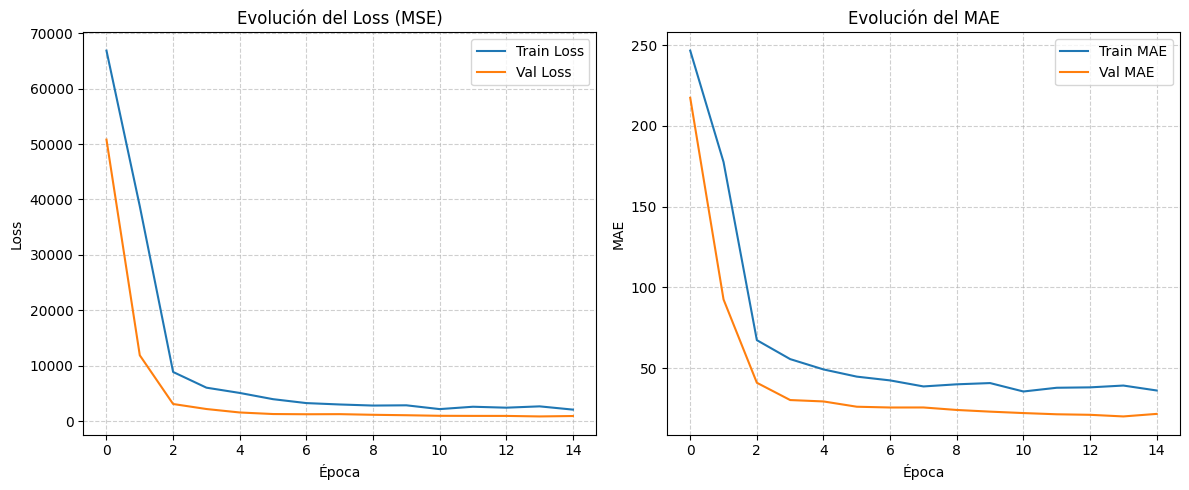

In [ ]:
import matplotlib.pyplot as plt

# Obtener métricas del entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

# Crear figura
plt.figure(figsize=(12, 5))

# --- Gráfica 1: Pérdida (MSE) ---
plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Evolución del Loss (MSE)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- Gráfica 2: MAE ---
plt.subplot(1, 2, 2)
plt.plot(mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.title('Evolución del MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# ----------------------
# GUARDAR PREDICCIONES
# ----------------------
pred_df = pd.DataFrame({
    'sku': sku_test,
    'real_weight': y_test,
    'predicted_weight': y_pred
})
pred_path = os.path.join(base_dir, 'predicciones.csv')
pred_df.to_csv(pred_path, index=False)

print(f"✅ Predicciones guardadas en {pred_path}")

✅ Predicciones guardadas en /content/drive/My Drive/REGRESION_PESO/DATOS_T_ENLACES_IMAGENES/predicciones.csv


In [ ]:
### CODIGO COMPLETO


